<a href="https://colab.research.google.com/github/euguroglu/Machine-Learning-Projects/blob/master/Pytorch_CNN_Text_Recognition_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing libraries

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


## Data loading

In [83]:
transform = transforms.ToTensor()

In [84]:
train_data = datasets.MNIST(root='',train=True,download=True,transform=transform)

In [85]:
test_data = datasets.MNIST(root='',train=False,download=True,transform=transform)

In [86]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train
    StandardTransform
Transform: ToTensor()

In [87]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: 
    Split: Test
    StandardTransform
Transform: ToTensor()

In [88]:
train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10,shuffle=False)

## Demonstration of creating convolutional layer

In [89]:
conv1 = nn.Conv2d(1,6,3,1) # -----> 6 filters ---> pooling --> conv2
# 1 color channel, 6 filters, 3x3 kernel , 1 stride
conv2 = nn.Conv2d(6,16,3,1)
# 6 input filters from conv1, 16 filters(arbitrary), 3x3 kernel, 1 stride

In [90]:
for i, (X_train,y_train) in enumerate(train_data):
  break

X_train.shape 

torch.Size([1, 28, 28])

Transfrom X_train to 4d including batch size

In [91]:
x = X_train.view(1,1,28,28)

In [92]:
x

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [93]:
x = F.relu(conv1(x))

In [94]:
x.shape # reduced to 26x26 because in conv layer we set padding=0 which results losing some information on the edge borders

torch.Size([1, 6, 26, 26])

In [95]:
x = F.max_pool2d(x,2,2) #2 kernel size, 2 stride

In [96]:
x.shape

torch.Size([1, 6, 13, 13])

In [97]:
x = F.relu(conv2(x))

In [98]:
x.shape

torch.Size([1, 16, 11, 11])

In [99]:
x = F.max_pool2d(x,2,2)

In [100]:
x.shape

torch.Size([1, 16, 5, 5])

In [101]:
x.view(-1,16*5*5).shape

torch.Size([1, 400])

## Creating CNN

In [102]:
class ConvolutionalNetwork(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    self.fc1 = nn.Linear(5*5*16,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)

  def forward(self,X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2)
    X = X.view(-1,16*5*5)
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X,dim=1)

In [103]:
torch.manual_seed(42)

In [104]:
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Checking how many parameters we got

In [105]:
for param in model.parameters():
  print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


## Defining cost function and optimization

In [106]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

## Training

In [108]:
import time
start_time = time.time()

#Variables (Trackers)
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []
accuracy = []

#For loops epochs
for i in range(epochs):

  trn_corr = 0
  tst_corr = 0


#Train
  for b,(X_train,y_train) in enumerate(train_loader):
    b = b + 1

    y_pred = model(X_train) #not flattening (conv)
    loss = criterion(y_pred,y_train)

    predicted = torch.max(y_pred.data,1)[1]
    batch_corr = (predicted == y_train).sum() # True:1 / False:0 sum
    trn_corr = trn_corr + batch_corr

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (b%600 == 0):
      print('Epoch: {} Batch: {} Loss: {} Accuracy: {}'.format(i,b,loss.item(),(trn_corr//(b/10))))
      accuracy.append((trn_corr//(b/10)))
  train_losses.append(loss)
  train_correct.append(trn_corr)


#Test

  with torch.no_grad():
    for b, (X_test,y_test) in enumerate(test_loader):

      y_val = model(X_test)

      predicted = torch.max(y_val.data,1)[1]
      tst_corr = (predicted == y_test).sum()
      
  loss = criterion(y_val,y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)

current_time = time.time()
total = current_time - start_time
print('Training took {}  minutes'.format(total/60))

Epoch: 0 Batch: 600 Loss: 0.19493621587753296 Accuracy: 78.0
Epoch: 0 Batch: 1200 Loss: 0.660311222076416 Accuracy: 85.0
Epoch: 0 Batch: 1800 Loss: 0.019781699404120445 Accuracy: 88.0
Epoch: 0 Batch: 2400 Loss: 0.024787360802292824 Accuracy: 90.0
Epoch: 0 Batch: 3000 Loss: 0.0068846167996525764 Accuracy: 91.0
Epoch: 0 Batch: 3600 Loss: 0.010743791237473488 Accuracy: 92.0
Epoch: 0 Batch: 4200 Loss: 0.06590835750102997 Accuracy: 93.0
Epoch: 0 Batch: 4800 Loss: 0.008464288897812366 Accuracy: 93.0
Epoch: 0 Batch: 5400 Loss: 0.0003218436904717237 Accuracy: 93.0
Epoch: 0 Batch: 6000 Loss: 0.005068367812782526 Accuracy: 94.0
Epoch: 1 Batch: 600 Loss: 0.022547639906406403 Accuracy: 98.0
Epoch: 1 Batch: 1200 Loss: 0.23414397239685059 Accuracy: 97.0
Epoch: 1 Batch: 1800 Loss: 0.14506083726882935 Accuracy: 97.0
Epoch: 1 Batch: 2400 Loss: 0.0008040574612095952 Accuracy: 97.0
Epoch: 1 Batch: 3000 Loss: 0.00028602249221876264 Accuracy: 97.0
Epoch: 1 Batch: 3600 Loss: 0.21373359858989716 Accuracy: 97

## Result

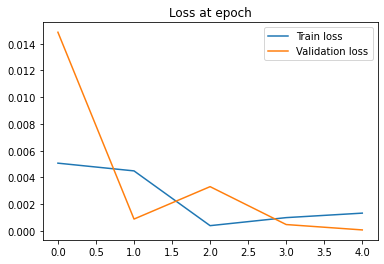

In [109]:
plt.plot(train_losses,label='Train loss')
plt.plot(test_losses,label='Validation loss')
plt.title('Loss at epoch')
plt.legend()
plt.show()

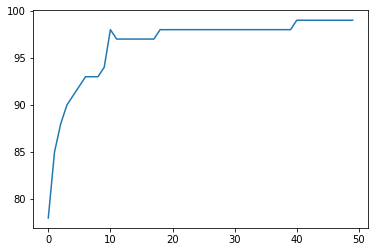

In [113]:
plt.plot(range(50),accuracy) # Accuracy per batch

## Evaluation with test data

In [114]:
test_load_all = DataLoader(test_data,batch_size=10000,shuffle=False)

In [115]:
with torch.no_grad():
  correct = 0
  for X_test,y_test in test_load_all:
    y_val = model(X_test)
    predicted = torch.max(y_val,1)[1]
    correct = correct +(predicted == y_test).sum()

In [118]:
correct.item()/len(test_data)*100

98.85000000000001

## Confusion Matrix

In [119]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 979    0    0    0    0    1    2    2    7    1]
 [   0 1126    3    0    0    0    3    2    0    1]
 [   0    0 1020    0    0    0    0   13    3    0]
 [   0    2    1 1007    0    6    0    3    2    3]
 [   0    0    2    0  973    0    1    0    0    5]
 [   0    2    0    2    0  879    1    0    0    6]
 [   0    1    0    0    2    1  950    0    0    0]
 [   0    1    6    1    0    0    0 1004    0    4]
 [   1    3    0    0    0    3    1    1  960    2]
 [   0    0    0    0    7    2    0    3    2  987]]


## Checking the model with completely new data

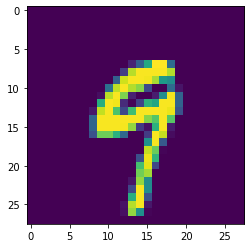

In [122]:
plt.imshow(test_data[2019][0].reshape(28,28))

In [123]:
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[2019][0].view(1,1,28,28))

In [125]:
new_prediction.argmax()

tensor(9)